# Part-of-Speech tagging using CRF

## Assignment Submitted by : Amarpal Singh

### <u>Table of Contents</u>


[1. Import Libraries and set required parameters](#library)

[2. Data Loading](#data)

[3. Merging sentences](#merge)

[4. Define Features](#define_features)

[5. Prepare data for CRF](#prepare_data_for_crf)

[6. Prediction using initial model](#initial_prediction)

[7. Hyperparameter tuning](#hyperparameter_tuning)

[8. Building a model with optimal hyperparams](#build_model_with_tuning)

[9. Save the model to a pickle file](#save_model)

[10.Evaluate the model performance](#evaluate_model)

[11.Interpret the model (enlist important state and transition features)](#interpret_model)



<a id='library'></a>

### Import  required libraries 

In [440]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn
import matplotlib.pyplot as plt
import random
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn_crfsuite import CRF


<a id='data'></a>

### Data Preparation

In [441]:
# reading the Treebank tagged sentences
wsj = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [442]:
# printing first few tagged sentences
print(wsj[:2])
print(len(wsj))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
3914


In [443]:
# reading the Brown tagged sentences
brown= list(nltk.corpus.brown.tagged_sents(tagset='universal'))

In [444]:
# first few tagged sentences
print(brown[:2])
print(len(brown))

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [445]:
# reading the conll2000 tagged sentences
conll2000= list(nltk.corpus.conll2000.tagged_sents(tagset='universal'))

In [446]:
# first few tagged sentences
print(conll2000[:2])
print(len(conll2000))

[[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if', 'ADP'), ('trade', 'NOUN'), ('figures', 'NOUN'), ('for', 'ADP'), ('September', 'NOUN'), (',', '.'), ('due', 'ADJ'), ('for', 'ADP'), ('release', 'NOUN'), ('tomorrow', 'NOUN'), (',', '.'), ('fail', 'VERB'), ('to', 'PRT'), ('show', 'VERB'), ('a', 'DET'), ('substantial', 'ADJ'), ('improvement', 'NOUN'), ('from', 'ADP'), ('July', 'NOUN'), ('and', 'CONJ'), ('August', 'NOUN'), ("'s", 'PRT'), ('near-record', 'ADJ'), ('deficits', 'NOUN'), ('.', '.')], [('Chancellor', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Exchequer', 'NOUN'), ('Nigel', 'NOUN'), ('Lawson', 'NOUN'), ("'s", 'PRT'), ('restated', 'VERB'), ('commitment', 'NOUN'), ('to', 'PRT'), ('a', 'DET'), ('firm', 'NOUN'), ('monetary', 'ADJ'), ('policy', 'NOUN'), ('has', 'VERB'), ('helped', 'VERB'), ('to', 'PRT'), ('prev

<a id='merge'></a>

### Merge sentences

In [447]:
nltk_data = wsj + brown + conll2000
#nltk_data = nltk_data[:100]
#nltk_data = wsj[100] + brown[100] + conll2000[100]

In [448]:
print(nltk_data[:2])
print(len(nltk_data))

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')]]
72202


In [449]:
#consolidated data 
tagged_sentences=nltk_data

<a id='define_features'></a>

### Define Features

In [450]:
def features(sentence, index):
    """ sentence: [w1, w2, ...], index: the index of the word """
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'prefix-3': sentence[index][:3],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
        'suffix-3': sentence[index][-3:],
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'has_hyphen': '-' in sentence[index],
        'is_numeric': sentence[index].isdigit(),
        'capitals_inside': sentence[index][1:].lower() != sentence[index][1:]
    }
 

<a id='prepare_data_for_crf'></a>

### Prepare data for CRF

In [451]:
from nltk.tag.util import untag
 
# Split the dataset for training and testing
cutoff = int(.80 * len(tagged_sentences))
training_sentences = tagged_sentences[:cutoff]
validation_sentences = tagged_sentences[cutoff:]
 
def transform_to_dataset(tagged_sentences):
    X, y = [], []
    for tagged in tagged_sentences:
        X.append([features(untag(tagged), index) for index in range(len(tagged))])
        y.append([tag for _, tag in tagged])
 
    return X, y
 
X_train, y_train = transform_to_dataset(training_sentences)
X_valid, y_valid = transform_to_dataset(validation_sentences)
 
print(len(X_train))     
print(len(X_valid))         
print(X_train[0])
print(y_train[0])
 


57761
14441
[{'word': 'Pierre', 'is_first': True, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'P', 'prefix-2': 'Pi', 'prefix-3': 'Pie', 'suffix-1': 'e', 'suffix-2': 're', 'suffix-3': 'rre', 'prev_word': '', 'next_word': 'Vinken', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': 'Vinken', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'is_all_caps': False, 'is_all_lower': False, 'prefix-1': 'V', 'prefix-2': 'Vi', 'prefix-3': 'Vin', 'suffix-1': 'n', 'suffix-2': 'en', 'suffix-3': 'ken', 'prev_word': 'Pierre', 'next_word': ',', 'has_hyphen': False, 'is_numeric': False, 'capitals_inside': False}, {'word': ',', 'is_first': False, 'is_last': False, 'is_capitalized': True, 'is_all_caps': True, 'is_all_lower': True, 'prefix-1': ',', 'prefix-2': ',', 'prefix-3': ',', 'suffix-1': ',', 'suffix-2': ',', 'suffix-3': ',', 'prev_word': 'Vinken', 'next_word': '61', 'has_hyphen': False, 'is_numeric': False,

<a id='build_crf'></a>

###  Build  CRF

In [452]:
model = CRF()
model.fit(X_train, y_train)



CRF(algorithm=None, all_possible_states=None, all_possible_transitions=None,
  averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
  calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [453]:
sentence = ['I', 'am', 'Bob', '!']
 
def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, model.predict([sentence_features])[0]))
 
print(pos_tag(sentence))  # [('I', 'PRP'), ('am', 'VBP'), ('Bob', 'NNP'), ('!', '.')]
 

[('I', 'PRON'), ('am', 'VERB'), ('Bob', 'NOUN'), ('!', '.')]


<a id='initial_prediction'></a>

###  Prediction using initial model

In [454]:

y_pred = model.predict(X_valid)
print(" The accuracy with the initial model using default parameters is:")
print(metrics.flat_accuracy_score(y_valid, y_pred))
metrics.flat_f1_score(y_valid, y_pred,average='weighted')
# 0.9602683593122289
 

 The accuracy with the initial model using default parameters is:
0.9438060158058392


0.9435019419876269

In [455]:
print(metrics.flat_classification_report(y_valid, y_pred, digits=3))

             precision    recall  f1-score   support

          .      0.996     0.999     0.998     41431
        ADJ      0.851     0.872     0.861     20932
        ADP      0.919     0.955     0.937     33697
        ADV      0.909     0.920     0.914     12425
       CONJ      0.992     0.997     0.994      8523
        DET      0.918     0.956     0.937     29936
       NOUN      0.965     0.950     0.957     89666
        NUM      0.984     0.993     0.989     10567
       PRON      0.939     0.789     0.857     11820
        PRT      0.806     0.781     0.793     10669
       VERB      0.959     0.964     0.962     47262
          X      0.359     0.218     0.271       170

avg / total      0.944     0.944     0.944    317098



The classification report tells us that:
- The overall f1-score (a weighted average of overall precision and recall) is 93.7%


Let's now try tuning the hyperparameters of CRF using grid search CV.

<a id='hyperparameter_tuning'></a>

## Hyperparameter tuning


In [456]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted')

In [457]:
from sklearn.model_selection import GridSearchCV

# instantiate a GridSearchCV object
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=2,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 40.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(flat_f1_score, average=weighted), verbose=1)

## store CV results in a DF

In [458]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_c1,param_c2,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,156.288139,5.171316,0.959800,0.994228,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",5,0.935091,0.995613,0.973037,0.993217,0.971273,0.993853,17.569096,0.671076,0.017487,0.001014
1,164.797873,5.235962,0.961140,0.991896,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",1,0.936413,0.993643,0.974579,0.990696,0.972429,0.991349,16.127418,1.261990,0.017507,0.001263
2,183.381213,5.950532,0.957890,0.980392,0.01,1,"{'c1': 0.01, 'c2': 1}",7,0.932928,0.983083,0.971764,0.978265,0.968978,0.979830,13.051571,1.004860,0.017688,0.002007
3,158.694621,4.662410,0.960790,0.993790,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",3,0.936136,0.995265,0.974068,0.992701,0.972168,0.993402,13.388229,0.812739,0.017451,0.001082
4,159.793190,4.661289,0.961133,0.991021,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",2,0.936542,0.992877,0.974614,0.989752,0.972244,0.990434,13.972707,0.754239,0.017416,0.001341
5,154.318671,4.539203,0.957665,0.979683,0.1,1,"{'c1': 0.1, 'c2': 1}",8,0.932735,0.982452,0.971570,0.977489,0.968690,0.979108,11.258538,0.669539,0.017667,0.002067
6,151.943821,4.337393,0.959885,0.980987,1,0.01,"{'c1': 1, 'c2': 0.01}",4,0.934909,0.983741,0.973691,0.978609,0.971057,0.980610,10.032598,0.600893,0.017694,0.002112
7,151.675735,4.411111,0.959261,0.979770,1,0.1,"{'c1': 1, 'c2': 0.1}",6,0.934304,0.982596,0.973172,0.977339,0.970308,0.979376,12.342690,0.783690,0.017686,0.002164
8,140.611860,4.349732,0.955585,0.974259,1,1,"{'c1': 1, 'c2': 1}",9,0.930801,0.977144,0.969499,0.971689,0.966457,0.973942,9.788489,1.011220,0.017569,0.002238


<a id='plot_cv_results'></a>

## Plotting CV results

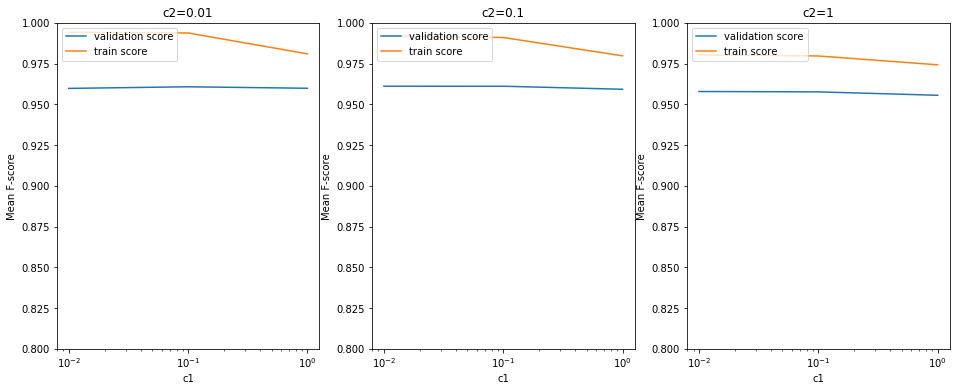

In [459]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and validation f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')

The plot above shows that at very low values of c_1, the model overfits, as shown by the difference in training and test performance. Also, the test score seems to be slightly higher for c_2 = 0.1.

Let's thus choose c_1 = 0.1 and c_2 = 0.1.

<a id='build_model_with_tuning'></a>

## Building a model with optimal hyperparams


In [460]:
# building a model with optimal hyperparams
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

<a id='save_model'></a>

## Save the model to a pickle file

In [461]:
# save the model to a pickle file
import _pickle as cPickle

with open('amarpal_singh_part_2.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close()   

Having tuned the model, we can now save (dump) it to a a pickle file so that we can simply import it and use later for predictions.

<a id='evaluate_model'></a>

### Evaluate the model performance

Now let's load the dumped model from the pkl file and use it for predictions.

In [462]:
# load the trained model
import _pickle as cPickle

with open('amarpal_singh_part_2.pkl', 'rb') as fid:
    crf = cPickle.load(fid)

Let's also make predictions on the test set and see the results. 

In [463]:

# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,average='weighted')

0.9463142916336001

The overall f1-score is comparable to that on training (cross-validation) data (which was about 94% on the test folds and 94% on training folds). Let's look at class-wise metrics as well.

In [464]:
print(metrics.flat_classification_report(y_valid, y_pred,  digits=3))

             precision    recall  f1-score   support

          .      0.997     0.999     0.998     41431
        ADJ      0.861     0.883     0.872     20932
        ADP      0.919     0.954     0.936     33697
        ADV      0.902     0.922     0.912     12425
       CONJ      0.992     0.997     0.994      8523
        DET      0.922     0.957     0.939     29936
       NOUN      0.969     0.953     0.961     89666
        NUM      0.983     0.991     0.987     10567
       PRON      0.941     0.800     0.865     11820
        PRT      0.817     0.787     0.801     10669
       VERB      0.962     0.967     0.965     47262
          X      0.364     0.276     0.314       170

avg / total      0.947     0.947     0.946    317098



### Testing Tuned Model  on Sample Sentences

In [465]:
test_sentences = ["Show me flights from Denver to Nebraska departing after 8 p.m.",
                  "Android is a mobile operating system developed by Google based on a modified version of the Linux kernel.",
                  "Android is a mobile operating system developed by Google.",
                  "Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
                  "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
                  "Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
                  "Before entering politics, Donald Trump was a domineering businessman and a television personality.",
                  "The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
                  "This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
                  "Show me the cheapest round trips from Dallas to Atlanta",
                  "I would like to see flights from Denver to Philadelphia.",
                  "Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
                  "NASA invited social media users to experience the launch of ICESAT-2 Satellite."]


#print(test_sentences)

def pos_tag(sentence):
    sentence_features = [features(sentence, index) for index in range(len(sentence))]
    return list(zip(sentence, crf.predict([sentence_features])[0]))

for sentence  in test_sentences:
    word_list = sentence.split(' ')
    print(pos_tag(word_list)) 
    print("\n")
    

[('Show', 'VERB'), ('me', 'PRON'), ('flights', 'VERB'), ('from', 'ADP'), ('Denver', 'NOUN'), ('to', 'ADP'), ('Nebraska', 'NOUN'), ('departing', 'VERB'), ('after', 'ADP'), ('8', 'NUM'), ('p.m.', 'ADV')]


[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('based', 'VERB'), ('on', 'ADP'), ('a', 'DET'), ('modified', 'VERB'), ('version', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Linux', 'NOUN'), ('kernel.', 'NOUN')]


[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'VERB'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google.', 'NOUN')]


[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('

<a id='interpret_model'></a>

### Interpret the model (enlist important state and transition features)

In [466]:
# Important States

print(metrics.flat_classification_report(y_valid, y_pred,  digits=3))

             precision    recall  f1-score   support

          .      0.997     0.999     0.998     41431
        ADJ      0.861     0.883     0.872     20932
        ADP      0.919     0.954     0.936     33697
        ADV      0.902     0.922     0.912     12425
       CONJ      0.992     0.997     0.994      8523
        DET      0.922     0.957     0.939     29936
       NOUN      0.969     0.953     0.961     89666
        NUM      0.983     0.991     0.987     10567
       PRON      0.941     0.800     0.865     11820
        PRT      0.817     0.787     0.801     10669
       VERB      0.962     0.967     0.965     47262
          X      0.364     0.276     0.314       170

avg / total      0.947     0.947     0.946    317098



In [467]:
# Important Transitions

from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
X      -> X       6.713011
ADJ    -> NOUN    4.158628
PRT    -> VERB    2.596407
PRON   -> VERB    2.256371
DET    -> NOUN    2.228459
NOUN   -> NOUN    2.117816
ADP    -> NOUN    2.074906
NOUN   -> PRON    2.066308
VERB   -> NOUN    2.012016
ADV    -> ADJ     1.956625
NOUN   -> VERB    1.743743
DET    -> ADJ     1.619096
ADJ    -> ADJ     1.544749
ADJ    -> NUM     1.455056
ADV    -> ADV     1.349434
VERB   -> ADV     1.321068
VERB   -> PRT     1.312258
X      -> VERB    1.303986
ADP    -> DET     1.292291
DET    -> VERB    1.185211

Top unlikely transitions:
ADV    -> X       -1.280274
CONJ   -> NUM     -1.304113
ADP    -> .       -1.308848
X      -> ADP     -1.315454
X      -> NUM     -1.333903
DET    -> PRON    -1.405826
DET    -> DET     -1.444999
NUM    -> ADV     -1.465527
NUM    -> PRON    -1.508214
DET    -> .       -1.577582
.      -> NUM     -1.586267
NUM    -> DET     -1.798534
ADP    -> X       -1.838170
NUM    -> VERB    -2.074922
DET    -> CONJ   